## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import os
from os.path import basename

%matplotlib inline

##1a) Camera Calibration - Load Images

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9
ny = 6

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    #print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        if False:
            rootname = os.path.splitext(basename(fname))[0]
            #print(rootname)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            cv2.imwrite('./output_images/chessboard/' + rootname +'_Chessboard.jpg', img)
            plt.figure()
            plt.imshow(img)

##1) Camera Calibration - Actual Calibration

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,(img.shape[1],img.shape[0]),None, None)

for fname in images:
    img = cv2.imread(fname)
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    
    rootname = os.path.splitext(basename(fname))[0]
    cv2.imwrite('./output_images/undistorted/' + rootname +'_ChessboardUndistorted.jpg', dst)
    
    if False:
        f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
        ax1.imshow(img)
        ax1.set_title('Ori')
        ax2.imshow(dst)
        ax2.set_title('Undistorted')

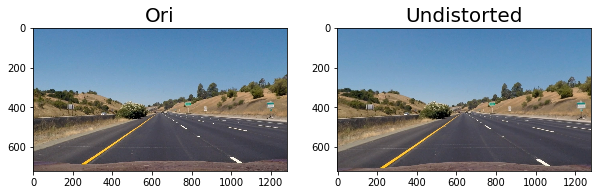

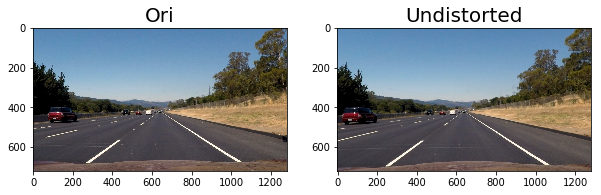

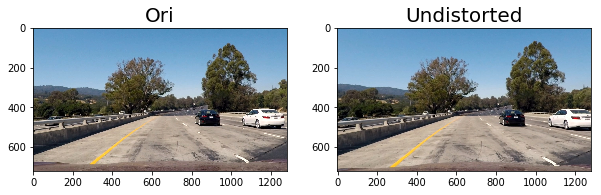

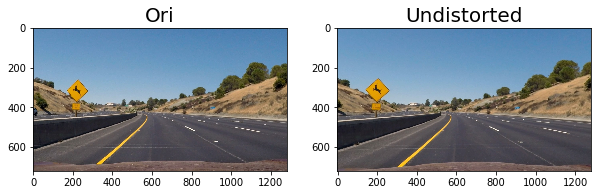

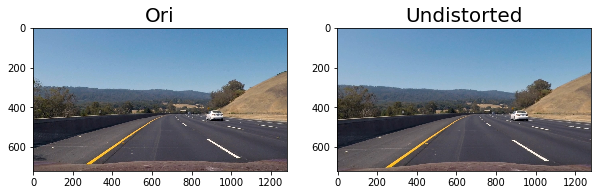

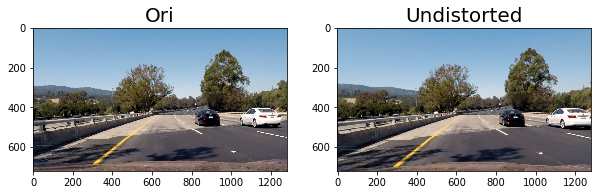

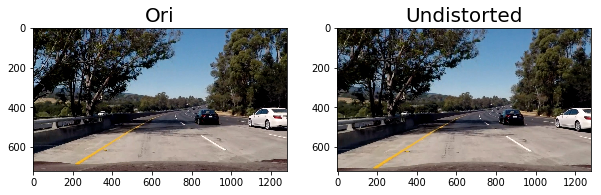

In [4]:
test_images = []
test_images_unsorted = []

images = glob.glob('test_images/*.jpg')

for fname in images:
    #print(fname)
    img = mpimg.imread(fname)
    test_images.append(img)
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    test_images_unsorted.append(dst)
    
    rootname = os.path.splitext(basename(fname))[0]
    cv2.imwrite('./output_images/undistorted/' + rootname +'_Undistorted.jpg', cv2.cvtColor(dst,cv2.COLOR_RGB2BGR))
    if True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.imshow(img)
        ax1.set_title('Ori', fontsize=20)
        ax2.imshow(dst)
        ax2.set_title('Undistorted', fontsize=20)
    

Check Projection

In [5]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    plt.imshow(sx_binary,cmap='gray')
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sx_binary

In [6]:
def perspective_swap(img, swap_back=False, draw_regions=False, plot_enable=False):
    img_size = [img.shape[1],img.shape[0]]
    
    srcpts = np.array(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

    dstpts = np.array(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
       
    if swap_back: 
        M = cv2.getPerspectiveTransform(np.float32([dstpts]), np.float32([srcpts]))
    else:
        M = cv2.getPerspectiveTransform(np.float32([srcpts]), np.float32([dstpts]))
    
    dst = cv2.warpPerspective(img, M, (img_size[0],img_size[1]), flags=cv2.INTER_LINEAR)
    
    dst2 = cv2.polylines(np.copy(dst), np.int32([dstpts]), 2, (255,0,0), thickness=3)
    img2 = cv2.polylines(np.copy(img), np.int32([srcpts]), 2, (255,0,0), thickness=3)
    
    if plot_enable:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Ori', fontsize=20)
        ax2.set_title('Transform', fontsize=20)
        
        if draw_regions:
            ax1.imshow(img2)
            ax2.imshow(dst2)
        else:
            ax1.imshow(img)
            ax2.imshow(dst)
            
    return dst

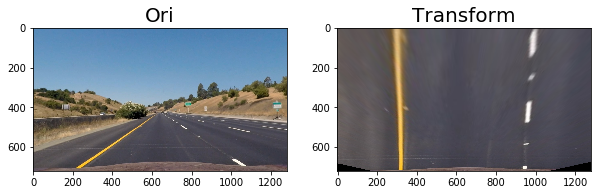

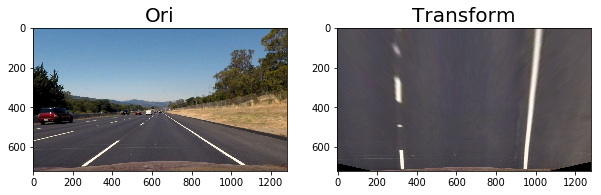

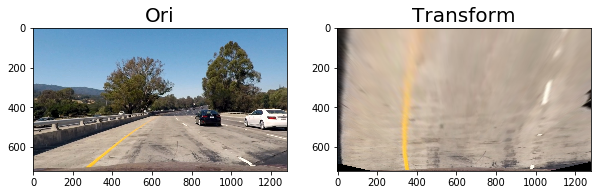

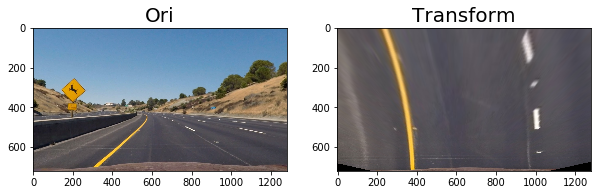

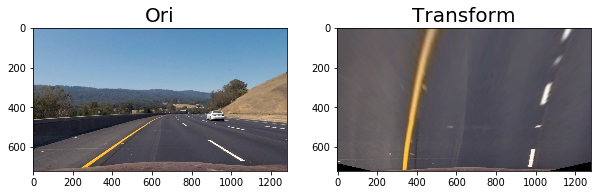

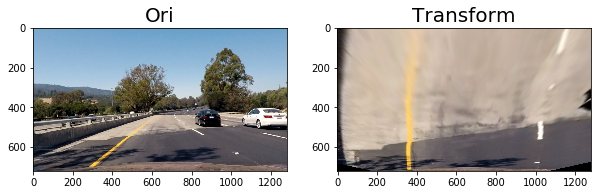

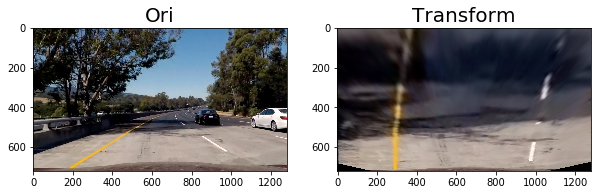

In [7]:
img_project_to = []

for cur_img in test_images_unsorted:
    dst = perspective_swap(cur_img,draw_regions=False,plot_enable=True)
    img_project_to.append(dst)

   


In [12]:
def conv2LSBinary(img, s_thresh = (170,255),sx_thresh=(20,100), sy_thresh=(20,100)):
    
    #Gray Image for Sobel
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    #Sobel X
    sx = cv2.Sobel(gray,cv2.CV_64F,1,0)
    sx = np.absolute(sx)
    sx_scaled = np.uint8(255*sx/np.max(sx))
    sx_binary = np.zeros_like(sx_scaled)
    sx_binary[(sx_scaled >= sx_thresh[0]) & (sx_scaled <= sx_thresh[1])] = 1
    
    #Sobel Y
    #sy = cv2.Sobel(gray,cv2.CV_64F,0,1)
    #sy = np.absolute(sy)
    #sy_scaled = np.uint8(255*sy/np.max(sy))
    #sy_binary = np.zeros_like(sy_scaled)
    #sy_binary[(sy_scaled >= sy_thresh[0]) & (sy_scaled <= sy_thresh[1])] = 1
    
    #Extract Saturation
    img_hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    saturation = img_hls[:,:,2]
    
    #Saturation Thresholding
    sat = np.absolute(saturation)
    #sat_scaled = np.uint8(255*sat/np.max(sat))
    saturation_bin = np.zeros_like(sat)
    saturation_bin[(sat >= s_thresh[0]) & (sat <= s_thresh[1])] = 1
    
    #Combine Thresholds
    sxy_binary = np.zeros_like(sx_binary)
    sxy_binary[(sx_binary==1) | (saturation_bin==1)] = 1
    
    return sxy_binary


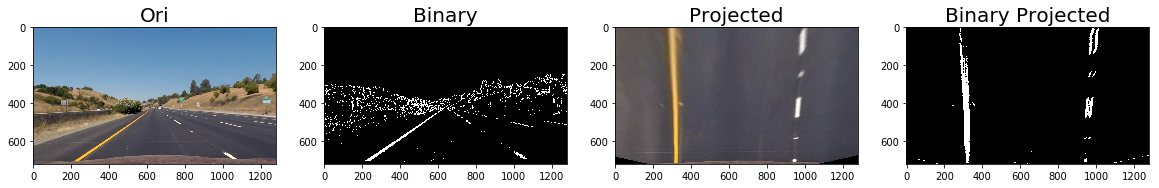

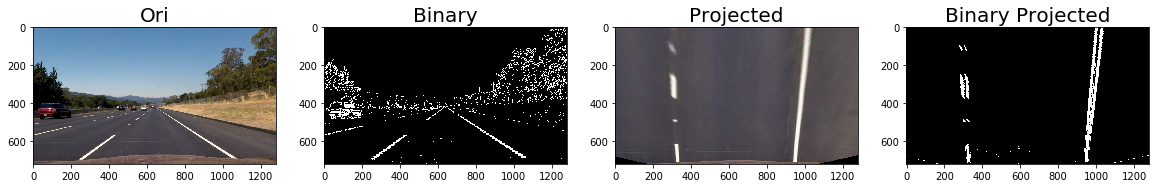

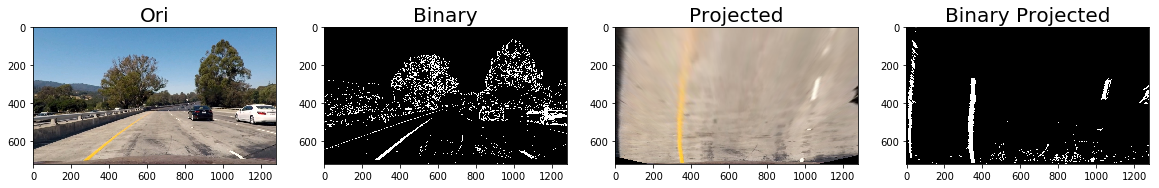

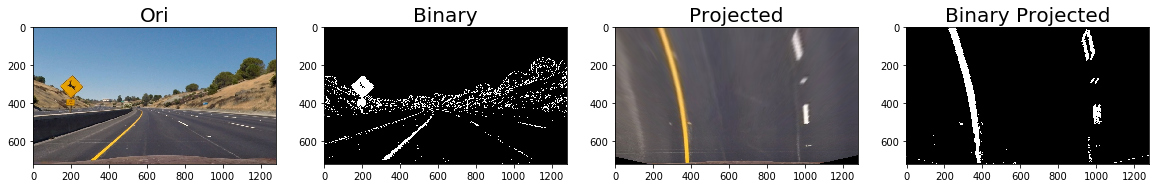

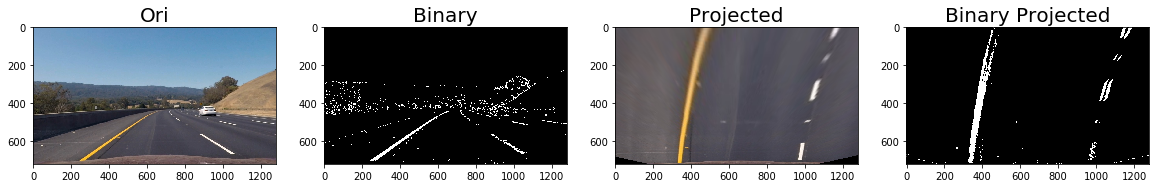

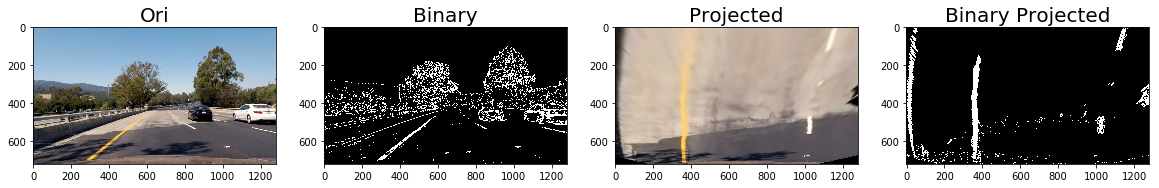

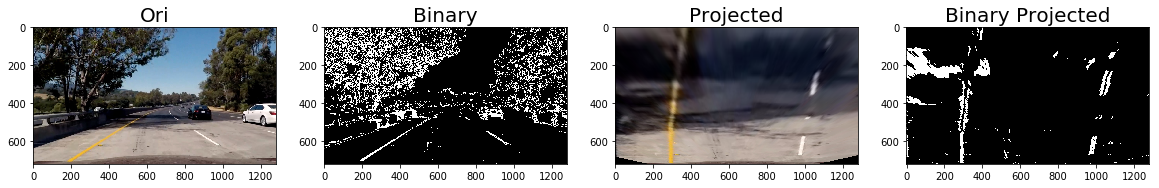

In [13]:
bin_warp_imgs = []

for cur_img, cur_img_proj in zip(test_images_unsorted, img_project_to):
    img_out_bin = conv2LSBinary(cur_img)
    img_out_projected_Bin = conv2LSBinary(cur_img_proj)
    bin_warp_imgs.append(img_out_projected_Bin)
    if True:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
        ax1.set_title('Ori', fontsize=20)
        ax1.imshow(cur_img)
        ax2.set_title('Binary', fontsize=20)
        ax2.imshow(img_out_bin, cmap='gray')
        ax3.set_title('Projected', fontsize=20)
        ax3.imshow(cur_img_proj, cmap='gray')
        ax4.set_title('Binary Projected', fontsize=20)
        ax4.imshow(img_out_projected_Bin, cmap='gray')

In [22]:
def detect_lane_edges(bin_warped_img, plot_enable=False):
    output_img = np.dstack((bin_warped_img,bin_warped_img,bin_warped_img))*255
    histogram = np.sum(bin_warped_img[int(bin_warped_img.shape[0]/2):,:], axis=0)
    histograminv = bin_warped_img.shape[0] - histogram
    
    window_count = 9
    window_height = bin_warped_img.shape[0] / window_count
    window_height = int(window_height)
    window_deltaX = 75
    
    midpoint = np.int(histogram.shape[0]/2)
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    
    # Multiple Windows worth of px for polyfit
    left_lane_inds = []
    right_lane_inds = []
    
    nonzero = bin_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_window_anchor = leftx_base
    
    right_window_anchor = rightx_base
    
    for cur_win in range(window_count):
        
        # Shared Top / Bottom
        bottom = bin_warped_img.shape[0] - window_height * (cur_win + 1)
        top = bin_warped_img.shape[0] - window_height * (cur_win)
        
        # L/R for Left Window
        Lleft = int(left_window_anchor) - window_deltaX
        Lright = int(left_window_anchor) + window_deltaX
        cv2.rectangle(output_img,(Lright,bottom),(Lleft,top),color=(0,255,0),thickness=2)
        validpx = ((nonzeroy < top) & (nonzeroy > bottom) & (nonzerox > Lleft) & (nonzerox < Lright)).nonzero()[0]
        left_lane_inds.append(validpx)
        if len(validpx) > 100:
            meanX = np.int(np.mean(nonzerox[validpx]))
            if meanX > window_deltaX & meanX < bin_warped_img.shape[1]-window_deltaX:
                left_window_anchor = meanX
        
        # L/R for Right Window
        Rleft = int(right_window_anchor) - window_deltaX
        Rright = int(right_window_anchor) + window_deltaX
        cv2.rectangle(output_img,(Rright,bottom),(Rleft,top),color=(0,255,0),thickness=2)
        validpx = ((nonzeroy < top) & (nonzeroy > bottom) & (nonzerox > Rleft) & (nonzerox < Rright)).nonzero()[0]
        right_lane_inds.append(validpx)
        if len(validpx) > 100:
            meanX = np.int(np.mean(nonzerox[validpx]))
            if meanX > window_deltaX & meanX < bin_warped_img.shape[1]-window_deltaX:
                right_window_anchor = meanX
        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    #Fit the lines
    left_line = np.polyfit(nonzeroy[left_lane_inds], nonzerox[left_lane_inds], 2)
    right_line = np.polyfit(nonzeroy[right_lane_inds], nonzerox[right_lane_inds], 2)
    
    ploty = np.linspace(0, bin_warped_img.shape[0]-1, bin_warped_img.shape[0])
    left_fitx = left_line[0]*ploty**2 + left_line[1]*ploty + left_line[2]
    right_fitx = right_line[0]*ploty**2 + right_line[1]*ploty + right_line[2]
    
    #Used Left px == blue
    output_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #Used Right px == blue
    output_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
 
    if plot_enable:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
        ax1.set_title('Ori', fontsize=20)
        ax1.imshow(bin_warped_img, cmap='gray')
        ax2.imshow(bin_warped_img, cmap='gray')
        ax2.imshow(output_img)
        ax2.plot(histograminv, color='pink')
        ax2.plot(left_fitx,ploty, color='c')
        ax2.plot(right_fitx,ploty, color='c')
        
    return (left_line,right_line)


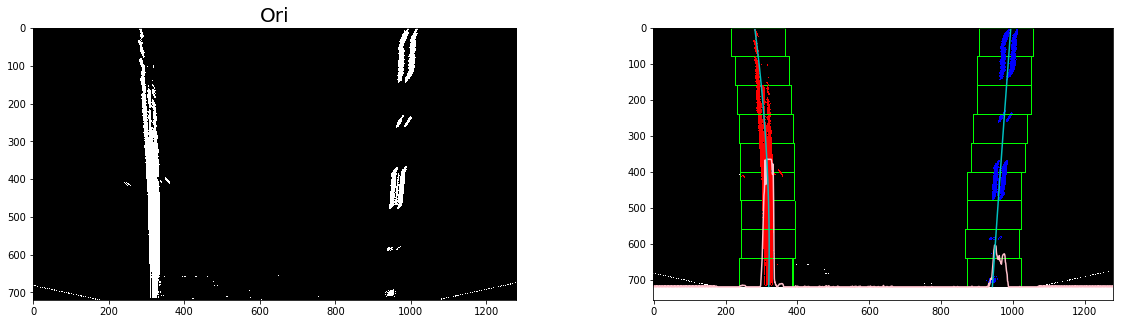

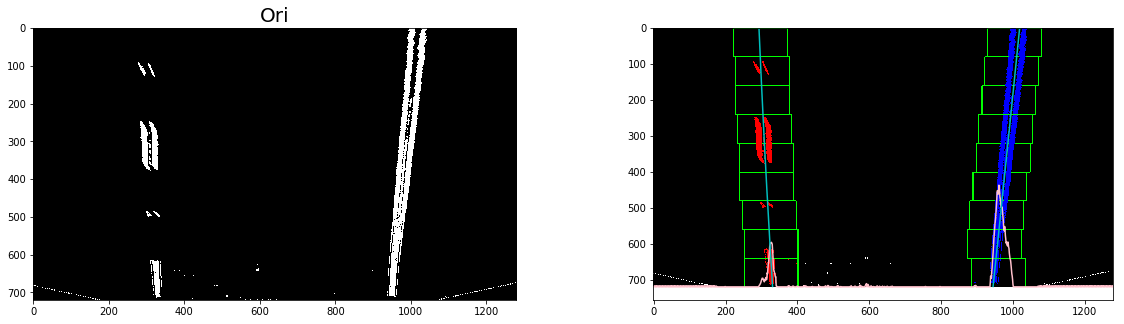

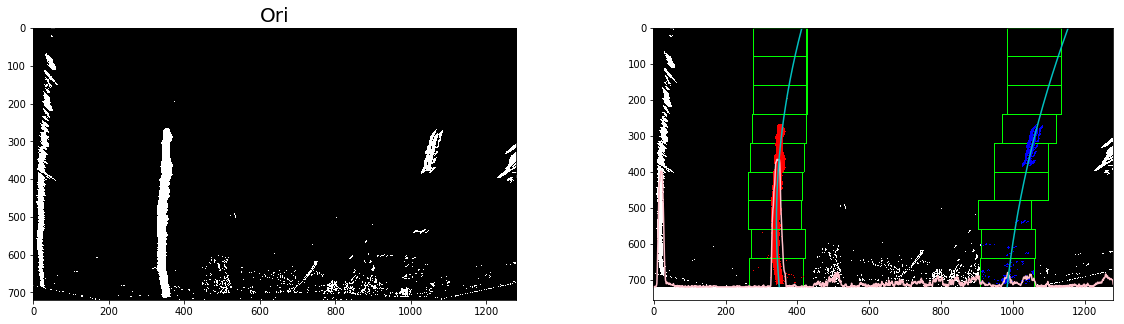

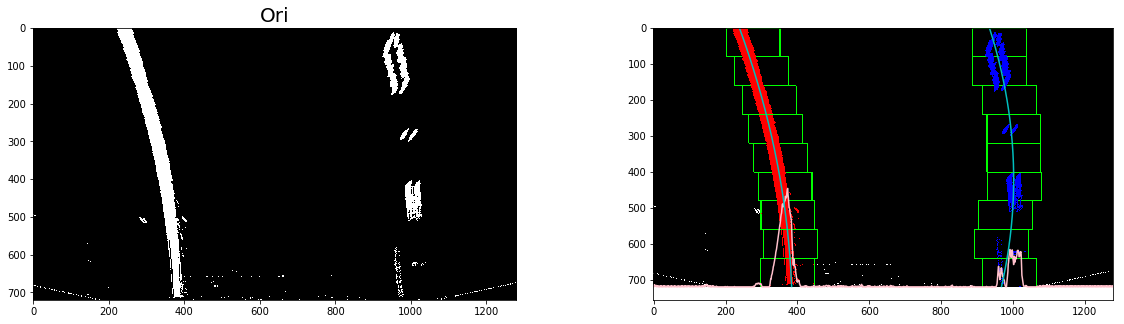

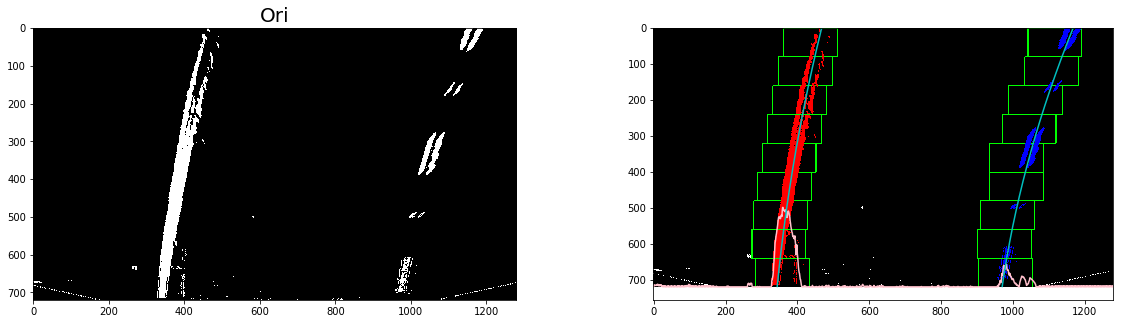

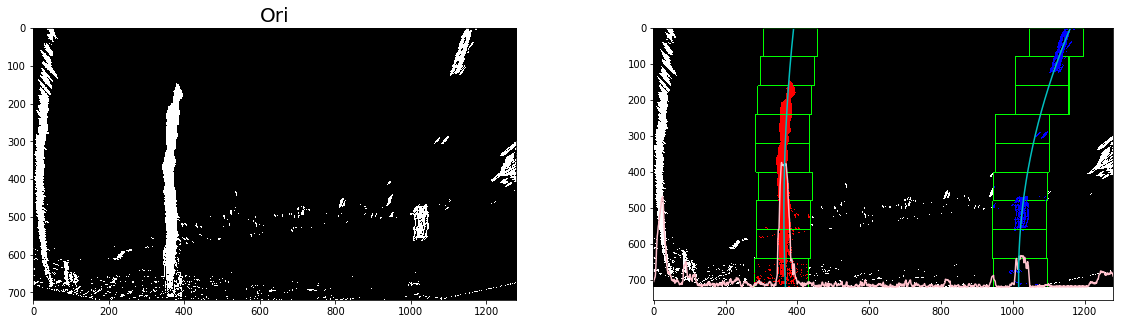

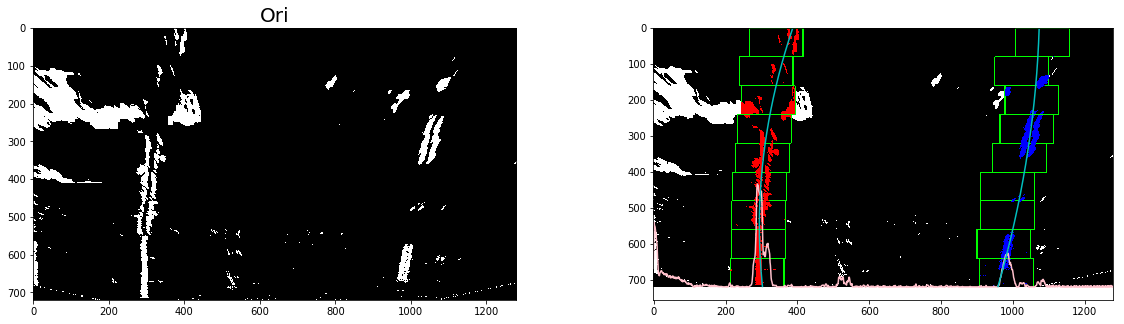

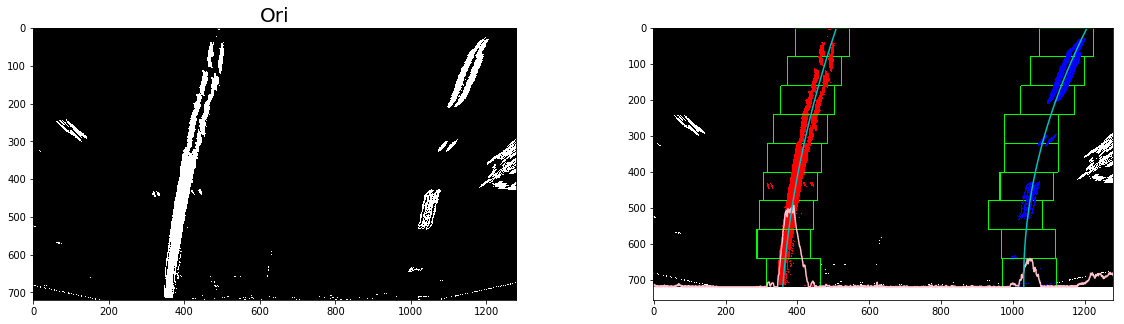

In [24]:
detectedLanes = []
for img in bin_warp_imgs:
    detectedLanes.append(detect_lane_edges(img, plot_enable=True))
    

In [25]:
def LanePoly(img,plot_enable=False):
    
    limits = detect_lane_edges(img)
    
    laneleft = limits[0]
    laneright = limits[1]
    
    ploty = np.linspace(0,img.shape[0]-1, img.shape[0])
    leftcoords = laneleft[0]*ploty**2 + laneleft[1]*ploty + laneleft[2]
    rightcoords = laneright[0]*ploty**2 + laneright[1]*ploty + laneright[2] 
    
    left = np.dstack((leftcoords,ploty))
    right = np.fliplr(np.dstack((rightcoords, ploty)))
    cmb = np.hstack((left,right)).astype('int')
    
    img_mask = np.zeros_like(img)
    cv2.fillPoly(img_mask,cmb,255)
    img_masked = cv2.bitwise_and(np.ones_like(img),img_mask)
    
    img_out = np.dstack(( np.zeros_like(img),img_masked*255,np.zeros_like(img)))
    if plot_enable:    
        plt.figure()
        plt.imshow(img_out)
        plt.show()
    
    return img_out


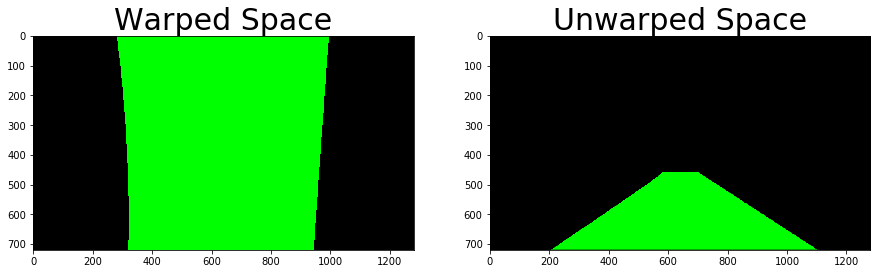

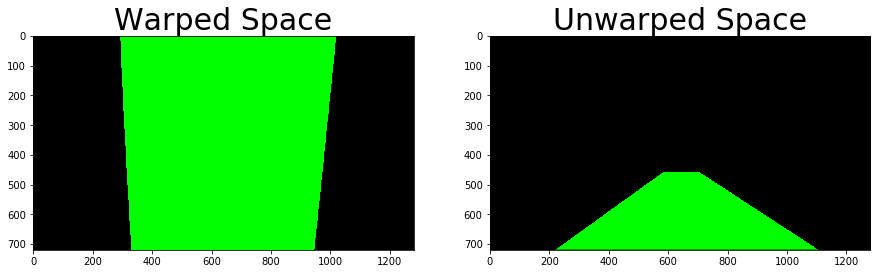

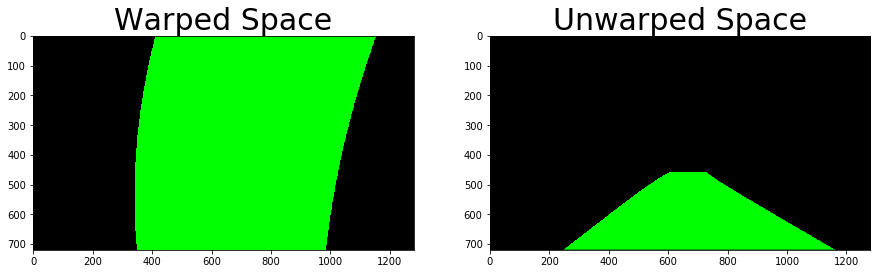

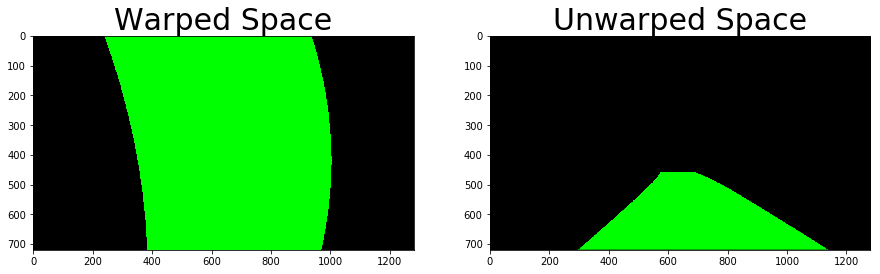

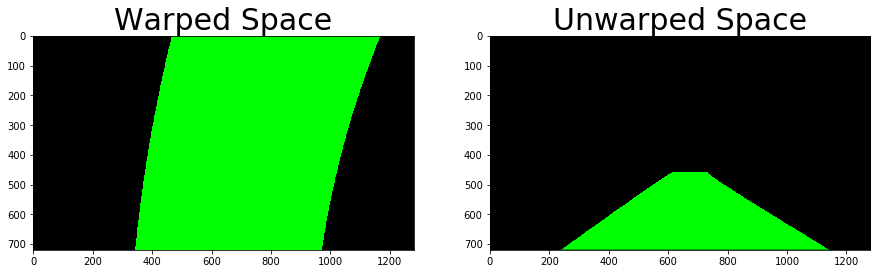

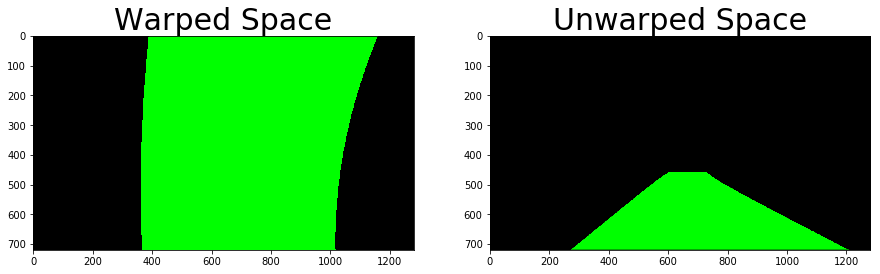

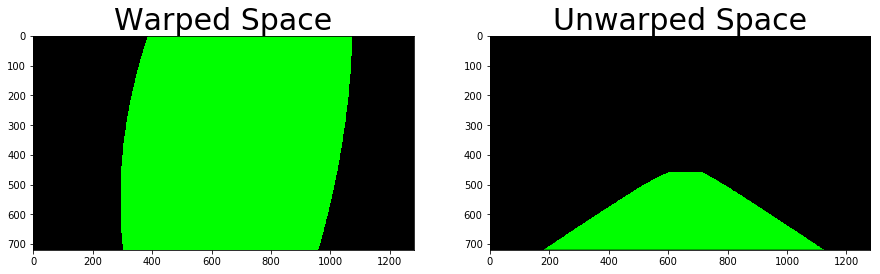

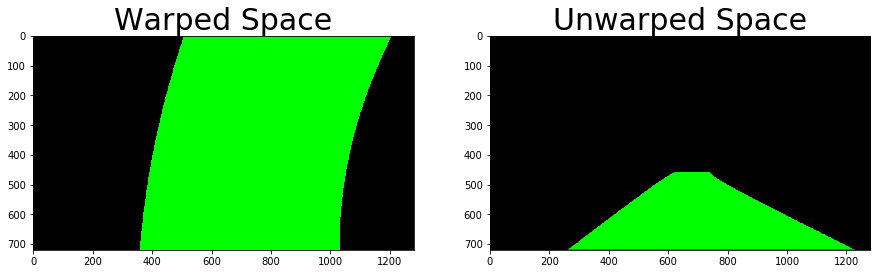

In [26]:
img_lane_masks = []
for img in bin_warp_imgs:
    img_warped = LanePoly(img)
    
    img_warped_back = perspective_swap(img_warped, swap_back=True)
    img_lane_masks.append(img_warped_back)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
    ax1.set_title('Warped Space', fontsize=30)
    ax1.imshow(img_warped)
    ax2.set_title('Unwarped Space', fontsize=30)
    ax2.imshow(img_warped_back)

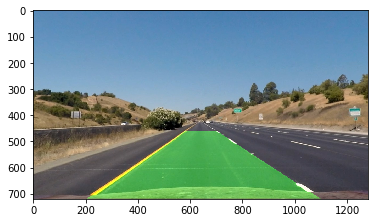

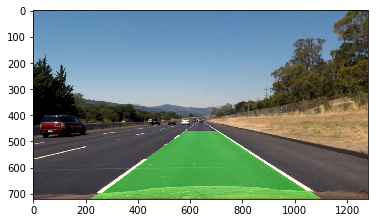

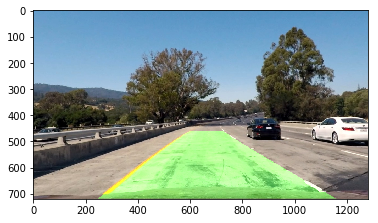

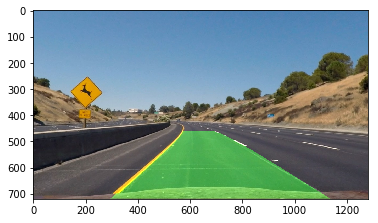

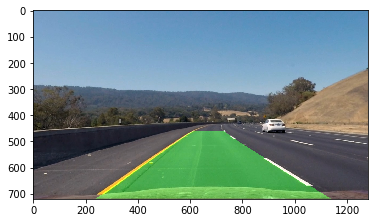

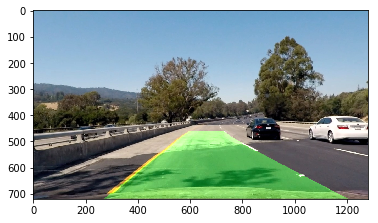

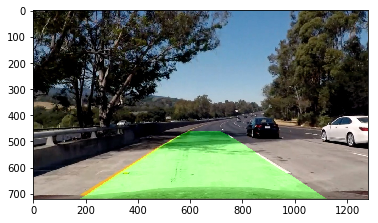

In [27]:
for img,overlay in zip(test_images_unsorted,img_lane_masks):
    img_overlayed = cv2.addWeighted(img, 1, overlay, 0.4, 0.0)
    plt.figure()
    plt.imshow(img_overlayed)

In [28]:
def LineFinder(img):
    
    #Undistort incoming frame
    img_undist = cv2.undistort(img,mtx,dist,None,mtx)
    
    #Warp image to birdseye view
    img_be = perspective_swap(img_undist)
    
    #Binary Threshold the Warped image
    img_be_bin = conv2LSBinary(img_be)
    
    #Detect Lane edges
    img_warped = LanePoly(img_be_bin)
    
    #Warp the Lane back to normal coordinates
    img_warped_back = perspective_swap(img_warped, swap_back=True)
    
    #Overlay calculated lane on original image
    img_overlayed = cv2.addWeighted(img_undist, 1, img_warped_back, 0.4, 0.0)
    
    if False:
        f, (ax1, ax2)  = plt.subplots(1, 2, figsize=(20,30))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax1.imshow(img_undist)
        ax2.set_title('Warped Image', fontsize=20)
        ax2.imshow(img_be)
        
        f, (ax1, ax2)  = plt.subplots(1, 2, figsize=(20,30))
        ax1.set_title('Warped Thresh Image', fontsize=20)
        ax1.imshow(img_be_bin, cmap='gray')
        ax2.set_title('Lane Lines Warped', fontsize=20)
        ax2.imshow(img_warped)
        
        f, (ax1, ax2)  = plt.subplots(1, 2, figsize=(20,30))
        ax1.set_title('Unwarped Thresh Image', fontsize=20)
        ax1.imshow(img_warped_back, cmap='gray')
        ax2.set_title('Final Frame', fontsize=20)
        ax2.imshow(img_overlayed)
 
    return img_overlayed

In [29]:
tmp = LineFinder(test_images[0])


In [18]:
project_output_file = "project_output.mp4"
project_video = VideoFileClip("./project_video.mp4")
project_output = project_video.fl_image(LineFinder)
%time project_output.write_videofile(project_output_file, audio=False)

[MoviePy] >>>> Building video project_output.mp4


[MoviePy] Writing video project_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:27,  8.53it/s]

  0%|          | 2/1261 [00:00<02:24,  8.72it/s]

  0%|          | 3/1261 [00:00<02:27,  8.54it/s]

  0%|          | 4/1261 [00:00<02:25,  8.65it/s]

  0%|          | 5/1261 [00:00<02:22,  8.79it/s]

  0%|          | 6/1261 [00:00<02:19,  9.00it/s]

  1%|          | 7/1261 [00:00<02:17,  9.09it/s]

  1%|          | 8/1261 [00:00<02:15,  9.25it/s]

  1%|          | 9/1261 [00:00<02:12,  9.43it/s]

  1%|          | 10/1261 [00:01<02:10,  9.58it/s]

  1%|          | 11/1261 [00:01<02:16,  9.16it/s]

  1%|          | 12/1261 [00:01<02:14,  9.28it/s]

  1%|          | 13/1261 [00:01<02:12,  9.45it/s]

  1%|          | 14/1261 [00:01<02:17,  9.04it/s]

  1%|          | 15/1261 [00:01<02:32,  8.16it/s]

  1%|▏         | 16/1261 [00:01<02:31,  8.24it/s]

  1%|▏         | 17/1261 [00:01<02:27,  8.46it/s]

  2%|▏         | 19/1261 [00:02<02:19,  8.90it/s]

  2%|▏         | 21/1261 [00:02<02:13,  9.27it/s]

  2%|▏         | 23/1261 [00:02<02:09,  9.59it/s]

  2%|▏         | 25/1261 [00:02<02:05,  9.84it/s]

  2%|▏         | 27/1261 [00:02<02:02, 10.05it/s]

  2%|▏         | 29/1261 [00:03<02:01, 10.16it/s]

  2%|▏         | 31/1261 [00:03<01:59, 10.26it/s]

  3%|▎         | 33/1261 [00:03<01:58, 10.32it/s]

  3%|▎         | 35/1261 [00:03<01:58, 10.38it/s]

  3%|▎         | 37/1261 [00:03<01:56, 10.53it/s]

  3%|▎         | 39/1261 [00:04<01:54, 10.66it/s]

  3%|▎         | 41/1261 [00:04<01:53, 10.73it/s]

  3%|▎         | 43/1261 [00:04<01:54, 10.66it/s]

  4%|▎         | 45/1261 [00:04<01:55, 10.57it/s]

  4%|▎         | 47/1261 [00:04<01:53, 10.66it/s]

  4%|▍         | 49/1261 [00:04<01:54, 10.62it/s]

  4%|▍         | 51/1261 [00:05<01:53, 10.64it/s]

  4%|▍         | 53/1261 [00:05<01:53, 10.64it/s]

  4%|▍         | 55/1261 [00:05<01:53, 10.59it/s]

  5%|▍         | 57/1261 [00:05<01:54, 10.56it/s]

  5%|▍         | 59/1261 [00:05<01:52, 10.68it/s]

  5%|▍         | 61/1261 [00:06<01:52, 10.63it/s]

  5%|▍         | 63/1261 [00:06<01:53, 10.57it/s]

  5%|▌         | 65/1261 [00:06<01:52, 10.66it/s]

  5%|▌         | 67/1261 [00:06<01:51, 10.72it/s]

  5%|▌         | 69/1261 [00:06<01:51, 10.72it/s]

  6%|▌         | 71/1261 [00:07<01:51, 10.71it/s]

  6%|▌         | 73/1261 [00:07<01:51, 10.69it/s]

  6%|▌         | 75/1261 [00:07<01:50, 10.72it/s]

  6%|▌         | 77/1261 [00:07<01:50, 10.70it/s]

  6%|▋         | 79/1261 [00:07<01:51, 10.59it/s]

  6%|▋         | 81/1261 [00:07<01:51, 10.63it/s]

  7%|▋         | 83/1261 [00:08<01:51, 10.59it/s]

  7%|▋         | 85/1261 [00:08<01:50, 10.60it/s]

  7%|▋         | 87/1261 [00:08<01:52, 10.47it/s]

  7%|▋         | 89/1261 [00:08<01:50, 10.56it/s]

  7%|▋         | 91/1261 [00:08<01:51, 10.51it/s]

  7%|▋         | 93/1261 [00:09<01:50, 10.57it/s]

  8%|▊         | 95/1261 [00:09<01:50, 10.58it/s]

  8%|▊         | 97/1261 [00:09<01:50, 10.57it/s]

  8%|▊         | 99/1261 [00:09<01:50, 10.52it/s]

  8%|▊         | 101/1261 [00:09<01:49, 10.58it/s]

  8%|▊         | 103/1261 [00:10<01:49, 10.58it/s]

  8%|▊         | 105/1261 [00:10<01:49, 10.60it/s]

  8%|▊         | 107/1261 [00:10<01:48, 10.67it/s]

  9%|▊         | 109/1261 [00:10<01:48, 10.63it/s]

  9%|▉         | 111/1261 [00:10<01:49, 10.55it/s]

  9%|▉         | 113/1261 [00:10<01:47, 10.64it/s]

  9%|▉         | 115/1261 [00:11<01:47, 10.62it/s]

  9%|▉         | 117/1261 [00:11<01:47, 10.66it/s]

  9%|▉         | 119/1261 [00:11<01:46, 10.73it/s]

 10%|▉         | 121/1261 [00:11<01:46, 10.71it/s]

 10%|▉         | 123/1261 [00:11<01:46, 10.70it/s]

 10%|▉         | 125/1261 [00:12<01:46, 10.69it/s]

 10%|█         | 127/1261 [00:12<01:46, 10.67it/s]

 10%|█         | 129/1261 [00:12<01:45, 10.69it/s]

 10%|█         | 131/1261 [00:12<01:45, 10.69it/s]

 11%|█         | 133/1261 [00:12<01:45, 10.71it/s]

 11%|█         | 135/1261 [00:13<01:45, 10.68it/s]

 11%|█         | 137/1261 [00:13<01:44, 10.79it/s]

 11%|█         | 139/1261 [00:13<01:44, 10.77it/s]

 11%|█         | 141/1261 [00:13<01:43, 10.83it/s]

 11%|█▏        | 143/1261 [00:13<01:43, 10.85it/s]

 11%|█▏        | 145/1261 [00:13<01:42, 10.88it/s]

 12%|█▏        | 147/1261 [00:14<01:43, 10.81it/s]

 12%|█▏        | 149/1261 [00:14<01:42, 10.80it/s]

 12%|█▏        | 151/1261 [00:14<01:43, 10.75it/s]

 12%|█▏        | 153/1261 [00:14<01:43, 10.74it/s]

 12%|█▏        | 155/1261 [00:14<01:43, 10.73it/s]

 12%|█▏        | 157/1261 [00:15<01:42, 10.78it/s]

 13%|█▎        | 159/1261 [00:15<01:42, 10.71it/s]

 13%|█▎        | 161/1261 [00:15<01:42, 10.74it/s]

 13%|█▎        | 163/1261 [00:15<01:42, 10.71it/s]

 13%|█▎        | 165/1261 [00:15<01:42, 10.66it/s]

 13%|█▎        | 167/1261 [00:16<01:43, 10.57it/s]

 13%|█▎        | 169/1261 [00:16<01:42, 10.60it/s]

 14%|█▎        | 171/1261 [00:16<01:43, 10.54it/s]

 14%|█▎        | 173/1261 [00:16<01:44, 10.37it/s]

 14%|█▍        | 175/1261 [00:16<01:45, 10.32it/s]

 14%|█▍        | 177/1261 [00:16<01:45, 10.28it/s]

 14%|█▍        | 179/1261 [00:17<01:44, 10.35it/s]

 14%|█▍        | 181/1261 [00:17<01:43, 10.48it/s]

 15%|█▍        | 183/1261 [00:17<01:43, 10.45it/s]

 15%|█▍        | 185/1261 [00:17<01:42, 10.54it/s]

 15%|█▍        | 187/1261 [00:17<01:41, 10.57it/s]

 15%|█▍        | 189/1261 [00:18<01:41, 10.60it/s]

 15%|█▌        | 191/1261 [00:18<01:40, 10.60it/s]

 15%|█▌        | 193/1261 [00:18<01:39, 10.74it/s]

 15%|█▌        | 195/1261 [00:18<01:39, 10.71it/s]

 16%|█▌        | 197/1261 [00:18<01:39, 10.73it/s]

 16%|█▌        | 199/1261 [00:19<01:39, 10.66it/s]

 16%|█▌        | 201/1261 [00:19<01:39, 10.70it/s]

 16%|█▌        | 203/1261 [00:19<01:39, 10.66it/s]

 16%|█▋        | 205/1261 [00:19<01:38, 10.77it/s]

 16%|█▋        | 207/1261 [00:19<01:37, 10.80it/s]

 17%|█▋        | 209/1261 [00:19<01:37, 10.82it/s]

 17%|█▋        | 211/1261 [00:20<01:37, 10.82it/s]

 17%|█▋        | 213/1261 [00:20<01:36, 10.86it/s]

 17%|█▋        | 215/1261 [00:20<01:36, 10.81it/s]

 17%|█▋        | 217/1261 [00:20<01:36, 10.85it/s]

 17%|█▋        | 219/1261 [00:20<01:36, 10.79it/s]

 18%|█▊        | 221/1261 [00:21<01:36, 10.72it/s]

 18%|█▊        | 223/1261 [00:21<01:37, 10.68it/s]

 18%|█▊        | 225/1261 [00:21<01:36, 10.79it/s]

 18%|█▊        | 227/1261 [00:21<01:36, 10.69it/s]

 18%|█▊        | 229/1261 [00:21<01:36, 10.68it/s]

 18%|█▊        | 231/1261 [00:22<01:36, 10.69it/s]

 18%|█▊        | 233/1261 [00:22<01:35, 10.79it/s]

 19%|█▊        | 235/1261 [00:22<01:36, 10.68it/s]

 19%|█▉        | 237/1261 [00:22<01:35, 10.71it/s]

 19%|█▉        | 239/1261 [00:22<01:35, 10.73it/s]

 19%|█▉        | 241/1261 [00:22<01:34, 10.78it/s]

 19%|█▉        | 243/1261 [00:23<01:34, 10.74it/s]

 19%|█▉        | 245/1261 [00:23<01:34, 10.71it/s]

 20%|█▉        | 247/1261 [00:23<01:35, 10.59it/s]

 20%|█▉        | 249/1261 [00:23<01:34, 10.71it/s]

 20%|█▉        | 251/1261 [00:23<01:34, 10.69it/s]

 20%|██        | 253/1261 [00:24<01:33, 10.76it/s]

 20%|██        | 255/1261 [00:24<01:33, 10.76it/s]

 20%|██        | 257/1261 [00:24<01:32, 10.80it/s]

 21%|██        | 259/1261 [00:24<01:34, 10.65it/s]

 21%|██        | 261/1261 [00:24<01:33, 10.68it/s]

 21%|██        | 263/1261 [00:25<01:33, 10.70it/s]

 21%|██        | 265/1261 [00:25<01:32, 10.76it/s]

 21%|██        | 267/1261 [00:25<01:32, 10.74it/s]

 21%|██▏       | 269/1261 [00:25<01:32, 10.77it/s]

 21%|██▏       | 271/1261 [00:25<01:31, 10.78it/s]

 22%|██▏       | 273/1261 [00:25<01:31, 10.82it/s]

 22%|██▏       | 275/1261 [00:26<01:32, 10.69it/s]

 22%|██▏       | 277/1261 [00:26<01:31, 10.76it/s]

 22%|██▏       | 279/1261 [00:26<01:30, 10.79it/s]

 22%|██▏       | 281/1261 [00:26<01:30, 10.85it/s]

 22%|██▏       | 283/1261 [00:26<01:30, 10.78it/s]

 23%|██▎       | 285/1261 [00:27<01:31, 10.72it/s]

 23%|██▎       | 287/1261 [00:27<01:31, 10.67it/s]

 23%|██▎       | 289/1261 [00:27<01:31, 10.66it/s]

 23%|██▎       | 291/1261 [00:27<01:31, 10.57it/s]

 23%|██▎       | 293/1261 [00:27<01:31, 10.62it/s]

 23%|██▎       | 295/1261 [00:28<01:31, 10.52it/s]

 24%|██▎       | 297/1261 [00:28<01:31, 10.50it/s]

 24%|██▎       | 299/1261 [00:28<01:31, 10.49it/s]

 24%|██▍       | 301/1261 [00:28<01:30, 10.62it/s]

 24%|██▍       | 303/1261 [00:28<01:29, 10.68it/s]

 24%|██▍       | 305/1261 [00:28<01:30, 10.56it/s]

 24%|██▍       | 307/1261 [00:29<01:29, 10.64it/s]

 25%|██▍       | 309/1261 [00:29<01:29, 10.69it/s]

 25%|██▍       | 311/1261 [00:29<01:28, 10.71it/s]

 25%|██▍       | 313/1261 [00:29<01:28, 10.76it/s]

 25%|██▍       | 315/1261 [00:29<01:27, 10.77it/s]

 25%|██▌       | 317/1261 [00:30<01:27, 10.79it/s]

 25%|██▌       | 319/1261 [00:30<01:27, 10.74it/s]

 25%|██▌       | 321/1261 [00:30<01:27, 10.80it/s]

 26%|██▌       | 323/1261 [00:30<01:27, 10.78it/s]

 26%|██▌       | 325/1261 [00:30<01:26, 10.85it/s]

 26%|██▌       | 327/1261 [00:30<01:26, 10.85it/s]

 26%|██▌       | 329/1261 [00:31<01:25, 10.86it/s]

 26%|██▌       | 331/1261 [00:31<01:25, 10.84it/s]

 26%|██▋       | 333/1261 [00:31<01:25, 10.83it/s]

 27%|██▋       | 335/1261 [00:31<01:26, 10.72it/s]

 27%|██▋       | 337/1261 [00:31<01:25, 10.79it/s]

 27%|██▋       | 339/1261 [00:32<01:24, 10.88it/s]

 27%|██▋       | 341/1261 [00:32<01:24, 10.86it/s]

 27%|██▋       | 343/1261 [00:32<01:24, 10.86it/s]

 27%|██▋       | 345/1261 [00:32<01:25, 10.74it/s]

 28%|██▊       | 347/1261 [00:32<01:25, 10.69it/s]

 28%|██▊       | 349/1261 [00:33<01:26, 10.56it/s]

 28%|██▊       | 351/1261 [00:33<01:26, 10.57it/s]

 28%|██▊       | 353/1261 [00:33<01:25, 10.62it/s]

 28%|██▊       | 355/1261 [00:33<01:25, 10.59it/s]

 28%|██▊       | 357/1261 [00:33<01:24, 10.67it/s]

 28%|██▊       | 359/1261 [00:33<01:24, 10.63it/s]

 29%|██▊       | 361/1261 [00:34<01:26, 10.44it/s]

 29%|██▉       | 363/1261 [00:34<01:25, 10.55it/s]

 29%|██▉       | 365/1261 [00:34<01:24, 10.59it/s]

 29%|██▉       | 367/1261 [00:34<01:24, 10.60it/s]

 29%|██▉       | 369/1261 [00:34<01:23, 10.65it/s]

 29%|██▉       | 371/1261 [00:35<01:24, 10.58it/s]

 30%|██▉       | 373/1261 [00:35<01:23, 10.67it/s]

 30%|██▉       | 375/1261 [00:35<01:23, 10.67it/s]

 30%|██▉       | 377/1261 [00:35<01:22, 10.73it/s]

 30%|███       | 379/1261 [00:35<01:22, 10.68it/s]

 30%|███       | 381/1261 [00:36<01:22, 10.70it/s]

 30%|███       | 383/1261 [00:36<01:21, 10.75it/s]

 31%|███       | 385/1261 [00:36<01:22, 10.63it/s]

 31%|███       | 387/1261 [00:36<01:22, 10.54it/s]

 31%|███       | 389/1261 [00:36<01:22, 10.53it/s]

 31%|███       | 391/1261 [00:36<01:23, 10.46it/s]

 31%|███       | 393/1261 [00:37<01:22, 10.52it/s]

 31%|███▏      | 395/1261 [00:37<01:22, 10.49it/s]

 31%|███▏      | 397/1261 [00:37<01:22, 10.46it/s]

 32%|███▏      | 399/1261 [00:37<01:22, 10.42it/s]

 32%|███▏      | 401/1261 [00:37<01:22, 10.47it/s]

 32%|███▏      | 403/1261 [00:38<01:21, 10.47it/s]

 32%|███▏      | 405/1261 [00:38<01:21, 10.55it/s]

 32%|███▏      | 407/1261 [00:38<01:21, 10.52it/s]

 32%|███▏      | 409/1261 [00:38<01:20, 10.61it/s]

 33%|███▎      | 411/1261 [00:38<01:19, 10.75it/s]

 33%|███▎      | 413/1261 [00:39<01:18, 10.78it/s]

 33%|███▎      | 415/1261 [00:39<01:18, 10.74it/s]

 33%|███▎      | 417/1261 [00:39<01:18, 10.81it/s]

 33%|███▎      | 419/1261 [00:39<01:18, 10.70it/s]

 33%|███▎      | 421/1261 [00:39<01:17, 10.78it/s]

 34%|███▎      | 423/1261 [00:39<01:17, 10.84it/s]

 34%|███▎      | 425/1261 [00:40<01:17, 10.80it/s]

 34%|███▍      | 427/1261 [00:40<01:17, 10.77it/s]

 34%|███▍      | 429/1261 [00:40<01:16, 10.81it/s]

 34%|███▍      | 431/1261 [00:40<01:16, 10.84it/s]

 34%|███▍      | 433/1261 [00:40<01:16, 10.82it/s]

 34%|███▍      | 435/1261 [00:41<01:16, 10.77it/s]

 35%|███▍      | 437/1261 [00:41<01:16, 10.82it/s]

 35%|███▍      | 439/1261 [00:41<01:16, 10.80it/s]

 35%|███▍      | 441/1261 [00:41<01:16, 10.67it/s]

 35%|███▌      | 443/1261 [00:41<01:17, 10.53it/s]

 35%|███▌      | 445/1261 [00:42<01:17, 10.48it/s]

 35%|███▌      | 447/1261 [00:42<01:17, 10.51it/s]

 36%|███▌      | 449/1261 [00:42<01:16, 10.57it/s]

 36%|███▌      | 451/1261 [00:42<01:16, 10.57it/s]

 36%|███▌      | 453/1261 [00:42<01:16, 10.53it/s]

 36%|███▌      | 455/1261 [00:42<01:16, 10.59it/s]

 36%|███▌      | 457/1261 [00:43<01:15, 10.68it/s]

 36%|███▋      | 459/1261 [00:43<01:14, 10.75it/s]

 37%|███▋      | 461/1261 [00:43<01:13, 10.86it/s]

 37%|███▋      | 463/1261 [00:43<01:14, 10.75it/s]

 37%|███▋      | 465/1261 [00:43<01:13, 10.81it/s]

 37%|███▋      | 467/1261 [00:44<01:13, 10.82it/s]

 37%|███▋      | 469/1261 [00:44<01:13, 10.80it/s]

 37%|███▋      | 471/1261 [00:44<01:12, 10.83it/s]

 38%|███▊      | 473/1261 [00:44<01:12, 10.88it/s]

 38%|███▊      | 475/1261 [00:44<01:13, 10.71it/s]

 38%|███▊      | 477/1261 [00:45<01:13, 10.62it/s]

 38%|███▊      | 479/1261 [00:45<01:13, 10.69it/s]

 38%|███▊      | 481/1261 [00:45<01:13, 10.65it/s]

 38%|███▊      | 483/1261 [00:45<01:12, 10.70it/s]

 38%|███▊      | 485/1261 [00:45<01:12, 10.71it/s]

 39%|███▊      | 487/1261 [00:45<01:12, 10.69it/s]

 39%|███▉      | 489/1261 [00:46<01:12, 10.66it/s]

 39%|███▉      | 491/1261 [00:46<01:11, 10.69it/s]

 39%|███▉      | 493/1261 [00:46<01:11, 10.70it/s]

 39%|███▉      | 495/1261 [00:46<01:16, 10.07it/s]

 39%|███▉      | 497/1261 [00:46<01:14, 10.25it/s]

 40%|███▉      | 499/1261 [00:47<01:13, 10.39it/s]

 40%|███▉      | 501/1261 [00:47<01:12, 10.54it/s]

 40%|███▉      | 503/1261 [00:47<01:12, 10.50it/s]

 40%|████      | 505/1261 [00:47<01:11, 10.53it/s]

 40%|████      | 507/1261 [00:47<01:11, 10.55it/s]

 40%|████      | 509/1261 [00:48<01:11, 10.53it/s]

 41%|████      | 511/1261 [00:48<01:11, 10.43it/s]

 41%|████      | 513/1261 [00:48<01:11, 10.48it/s]

 41%|████      | 515/1261 [00:48<01:11, 10.48it/s]

 41%|████      | 517/1261 [00:48<01:10, 10.53it/s]

 41%|████      | 519/1261 [00:49<01:12, 10.29it/s]

 41%|████▏     | 521/1261 [00:49<01:11, 10.40it/s]

 41%|████▏     | 523/1261 [00:49<01:10, 10.50it/s]

 42%|████▏     | 525/1261 [00:49<01:09, 10.63it/s]

 42%|████▏     | 527/1261 [00:49<01:09, 10.56it/s]

 42%|████▏     | 529/1261 [00:49<01:08, 10.70it/s]

 42%|████▏     | 531/1261 [00:50<01:07, 10.81it/s]

 42%|████▏     | 533/1261 [00:50<01:06, 10.90it/s]

 42%|████▏     | 535/1261 [00:50<01:06, 10.90it/s]

 43%|████▎     | 537/1261 [00:50<01:06, 10.90it/s]

 43%|████▎     | 539/1261 [00:50<01:06, 10.88it/s]

 43%|████▎     | 541/1261 [00:51<01:05, 10.92it/s]

 43%|████▎     | 543/1261 [00:51<01:05, 10.94it/s]

 43%|████▎     | 545/1261 [00:51<01:05, 11.00it/s]

 43%|████▎     | 547/1261 [00:51<01:04, 11.06it/s]

 44%|████▎     | 549/1261 [00:51<01:04, 11.10it/s]

 44%|████▎     | 551/1261 [00:51<01:03, 11.16it/s]

 44%|████▍     | 553/1261 [00:52<01:03, 11.09it/s]

 44%|████▍     | 555/1261 [00:52<01:03, 11.06it/s]

 44%|████▍     | 557/1261 [00:52<01:03, 11.04it/s]

 44%|████▍     | 559/1261 [00:52<01:04, 10.92it/s]

 44%|████▍     | 561/1261 [00:52<01:04, 10.90it/s]

 45%|████▍     | 563/1261 [00:53<01:04, 10.82it/s]

 45%|████▍     | 565/1261 [00:53<01:03, 10.89it/s]

 45%|████▍     | 567/1261 [00:53<01:03, 10.99it/s]

 45%|████▌     | 569/1261 [00:53<01:08, 10.11it/s]

 45%|████▌     | 571/1261 [00:53<01:06, 10.43it/s]

 45%|████▌     | 573/1261 [00:54<01:04, 10.63it/s]

 46%|████▌     | 575/1261 [00:54<01:03, 10.76it/s]

 46%|████▌     | 577/1261 [00:54<01:03, 10.85it/s]

 46%|████▌     | 579/1261 [00:54<01:03, 10.79it/s]

 46%|████▌     | 581/1261 [00:54<01:02, 10.88it/s]

 46%|████▌     | 583/1261 [00:54<01:01, 10.94it/s]

 46%|████▋     | 585/1261 [00:55<01:01, 10.93it/s]

 47%|████▋     | 587/1261 [00:55<01:01, 10.98it/s]

 47%|████▋     | 589/1261 [00:55<01:01, 10.98it/s]

 47%|████▋     | 591/1261 [00:55<01:00, 11.06it/s]

 47%|████▋     | 593/1261 [00:55<01:00, 11.08it/s]

 47%|████▋     | 595/1261 [00:56<01:00, 11.09it/s]

 47%|████▋     | 597/1261 [00:56<00:59, 11.14it/s]

 48%|████▊     | 599/1261 [00:56<00:59, 11.18it/s]

 48%|████▊     | 601/1261 [00:56<00:59, 11.18it/s]

 48%|████▊     | 603/1261 [00:56<00:59, 11.14it/s]

 48%|████▊     | 605/1261 [00:56<00:59, 11.09it/s]

 48%|████▊     | 607/1261 [00:57<00:59, 10.96it/s]

 48%|████▊     | 609/1261 [00:57<01:01, 10.66it/s]

 48%|████▊     | 611/1261 [00:57<01:01, 10.56it/s]

 49%|████▊     | 613/1261 [00:57<01:01, 10.56it/s]

 49%|████▉     | 615/1261 [00:57<01:01, 10.52it/s]

 49%|████▉     | 617/1261 [00:58<01:01, 10.51it/s]

 49%|████▉     | 619/1261 [00:58<01:01, 10.49it/s]

 49%|████▉     | 621/1261 [00:58<01:00, 10.55it/s]

 49%|████▉     | 623/1261 [00:58<01:00, 10.59it/s]

 50%|████▉     | 625/1261 [00:58<00:59, 10.66it/s]

 50%|████▉     | 627/1261 [00:58<00:58, 10.81it/s]

 50%|████▉     | 629/1261 [00:59<00:58, 10.86it/s]

 50%|█████     | 631/1261 [00:59<00:58, 10.85it/s]

 50%|█████     | 633/1261 [00:59<00:58, 10.82it/s]

 50%|█████     | 635/1261 [00:59<00:58, 10.78it/s]

 51%|█████     | 637/1261 [00:59<00:57, 10.83it/s]

 51%|█████     | 639/1261 [01:00<00:56, 10.94it/s]

 51%|█████     | 641/1261 [01:00<00:56, 10.93it/s]

 51%|█████     | 643/1261 [01:00<00:56, 10.87it/s]

 51%|█████     | 645/1261 [01:00<00:56, 10.87it/s]

 51%|█████▏    | 647/1261 [01:00<00:56, 10.92it/s]

 51%|█████▏    | 649/1261 [01:01<00:56, 10.84it/s]

 52%|█████▏    | 651/1261 [01:01<00:55, 10.90it/s]

 52%|█████▏    | 653/1261 [01:01<00:55, 10.94it/s]

 52%|█████▏    | 655/1261 [01:01<00:55, 10.96it/s]

 52%|█████▏    | 657/1261 [01:01<00:57, 10.50it/s]

 52%|█████▏    | 659/1261 [01:01<00:56, 10.66it/s]

 52%|█████▏    | 661/1261 [01:02<00:56, 10.71it/s]

 53%|█████▎    | 663/1261 [01:02<00:55, 10.78it/s]

 53%|█████▎    | 665/1261 [01:02<00:55, 10.84it/s]

 53%|█████▎    | 667/1261 [01:02<00:54, 10.82it/s]

 53%|█████▎    | 669/1261 [01:02<00:54, 10.80it/s]

 53%|█████▎    | 671/1261 [01:03<00:54, 10.73it/s]

 53%|█████▎    | 673/1261 [01:03<00:54, 10.74it/s]

 54%|█████▎    | 675/1261 [01:03<00:54, 10.77it/s]

 54%|█████▎    | 677/1261 [01:03<00:54, 10.81it/s]

 54%|█████▍    | 679/1261 [01:03<00:53, 10.86it/s]

 54%|█████▍    | 681/1261 [01:03<00:53, 10.82it/s]

 54%|█████▍    | 683/1261 [01:04<00:53, 10.87it/s]

 54%|█████▍    | 685/1261 [01:04<00:52, 10.87it/s]

 54%|█████▍    | 687/1261 [01:04<00:52, 10.88it/s]

 55%|█████▍    | 689/1261 [01:04<00:52, 10.85it/s]

 55%|█████▍    | 691/1261 [01:04<00:52, 10.86it/s]

 55%|█████▍    | 693/1261 [01:05<00:52, 10.87it/s]

 55%|█████▌    | 695/1261 [01:05<00:52, 10.86it/s]

 55%|█████▌    | 697/1261 [01:05<00:51, 10.90it/s]

 55%|█████▌    | 699/1261 [01:05<00:51, 10.89it/s]

 56%|█████▌    | 701/1261 [01:05<00:51, 10.93it/s]

 56%|█████▌    | 703/1261 [01:05<00:50, 10.96it/s]

 56%|█████▌    | 705/1261 [01:06<00:50, 10.96it/s]

 56%|█████▌    | 707/1261 [01:06<00:50, 10.91it/s]

 56%|█████▌    | 709/1261 [01:06<00:50, 10.93it/s]

 56%|█████▋    | 711/1261 [01:06<00:50, 10.97it/s]

 57%|█████▋    | 713/1261 [01:06<00:50, 10.87it/s]

 57%|█████▋    | 715/1261 [01:07<00:50, 10.75it/s]

 57%|█████▋    | 717/1261 [01:07<00:50, 10.70it/s]

 57%|█████▋    | 719/1261 [01:07<00:50, 10.80it/s]

 57%|█████▋    | 721/1261 [01:07<00:49, 10.82it/s]

 57%|█████▋    | 723/1261 [01:07<00:49, 10.77it/s]

 57%|█████▋    | 725/1261 [01:08<00:49, 10.78it/s]

 58%|█████▊    | 727/1261 [01:08<00:49, 10.88it/s]

 58%|█████▊    | 729/1261 [01:08<00:49, 10.81it/s]

 58%|█████▊    | 731/1261 [01:08<00:54,  9.72it/s]

 58%|█████▊    | 733/1261 [01:08<00:52, 10.05it/s]

 58%|█████▊    | 735/1261 [01:09<00:51, 10.24it/s]

 58%|█████▊    | 737/1261 [01:09<00:50, 10.45it/s]

 59%|█████▊    | 739/1261 [01:09<00:49, 10.63it/s]

 59%|█████▉    | 741/1261 [01:09<00:48, 10.70it/s]

 59%|█████▉    | 743/1261 [01:09<00:48, 10.79it/s]

 59%|█████▉    | 745/1261 [01:09<00:47, 10.78it/s]

 59%|█████▉    | 747/1261 [01:10<00:47, 10.78it/s]

 59%|█████▉    | 749/1261 [01:10<00:47, 10.83it/s]

 60%|█████▉    | 751/1261 [01:10<00:47, 10.80it/s]

 60%|█████▉    | 753/1261 [01:10<00:46, 10.84it/s]

 60%|█████▉    | 755/1261 [01:10<00:46, 10.88it/s]

 60%|██████    | 757/1261 [01:11<00:46, 10.82it/s]

 60%|██████    | 759/1261 [01:11<00:46, 10.79it/s]

 60%|██████    | 761/1261 [01:11<00:46, 10.82it/s]

 61%|██████    | 763/1261 [01:11<00:45, 10.89it/s]

 61%|██████    | 765/1261 [01:11<00:45, 10.83it/s]

 61%|██████    | 767/1261 [01:11<00:45, 10.78it/s]

 61%|██████    | 769/1261 [01:12<00:45, 10.78it/s]

 61%|██████    | 771/1261 [01:12<00:45, 10.71it/s]

 61%|██████▏   | 773/1261 [01:12<00:45, 10.67it/s]

 61%|██████▏   | 775/1261 [01:12<00:45, 10.75it/s]

 62%|██████▏   | 777/1261 [01:12<00:45, 10.71it/s]

 62%|██████▏   | 779/1261 [01:13<00:45, 10.69it/s]

 62%|██████▏   | 781/1261 [01:13<00:44, 10.76it/s]

 62%|██████▏   | 783/1261 [01:13<00:44, 10.80it/s]

 62%|██████▏   | 785/1261 [01:13<00:43, 10.82it/s]

 62%|██████▏   | 787/1261 [01:13<00:43, 10.81it/s]

 63%|██████▎   | 789/1261 [01:14<00:43, 10.81it/s]

 63%|██████▎   | 791/1261 [01:14<00:43, 10.80it/s]

 63%|██████▎   | 793/1261 [01:14<00:43, 10.75it/s]

 63%|██████▎   | 795/1261 [01:14<00:43, 10.65it/s]

 63%|██████▎   | 797/1261 [01:14<00:43, 10.70it/s]

 63%|██████▎   | 799/1261 [01:14<00:43, 10.73it/s]

 64%|██████▎   | 801/1261 [01:15<00:42, 10.80it/s]

 64%|██████▎   | 803/1261 [01:15<00:42, 10.71it/s]

 64%|██████▍   | 805/1261 [01:15<00:42, 10.73it/s]

 64%|██████▍   | 807/1261 [01:15<00:42, 10.75it/s]

 64%|██████▍   | 809/1261 [01:15<00:41, 10.83it/s]

 64%|██████▍   | 811/1261 [01:16<00:41, 10.85it/s]

 64%|██████▍   | 813/1261 [01:16<00:41, 10.80it/s]

 65%|██████▍   | 815/1261 [01:16<00:41, 10.72it/s]

 65%|██████▍   | 817/1261 [01:16<00:41, 10.75it/s]

 65%|██████▍   | 819/1261 [01:16<00:40, 10.78it/s]

 65%|██████▌   | 821/1261 [01:16<00:40, 10.73it/s]

 65%|██████▌   | 823/1261 [01:17<00:40, 10.73it/s]

 65%|██████▌   | 825/1261 [01:17<00:40, 10.73it/s]

 66%|██████▌   | 827/1261 [01:17<00:40, 10.66it/s]

 66%|██████▌   | 829/1261 [01:17<00:40, 10.68it/s]

 66%|██████▌   | 831/1261 [01:17<00:40, 10.58it/s]

 66%|██████▌   | 833/1261 [01:18<00:40, 10.62it/s]

 66%|██████▌   | 835/1261 [01:18<00:39, 10.69it/s]

 66%|██████▋   | 837/1261 [01:18<00:39, 10.77it/s]

 67%|██████▋   | 839/1261 [01:18<00:39, 10.72it/s]

 67%|██████▋   | 841/1261 [01:18<00:39, 10.74it/s]

 67%|██████▋   | 843/1261 [01:19<00:38, 10.77it/s]

 67%|██████▋   | 845/1261 [01:19<00:38, 10.80it/s]

 67%|██████▋   | 847/1261 [01:19<00:38, 10.74it/s]

 67%|██████▋   | 849/1261 [01:19<00:38, 10.81it/s]

 67%|██████▋   | 851/1261 [01:19<00:38, 10.77it/s]

 68%|██████▊   | 853/1261 [01:19<00:37, 10.80it/s]

 68%|██████▊   | 855/1261 [01:20<00:37, 10.79it/s]

 68%|██████▊   | 857/1261 [01:20<00:37, 10.80it/s]

 68%|██████▊   | 859/1261 [01:20<00:37, 10.74it/s]

 68%|██████▊   | 861/1261 [01:20<00:37, 10.60it/s]

 68%|██████▊   | 863/1261 [01:20<00:38, 10.46it/s]

 69%|██████▊   | 865/1261 [01:21<00:37, 10.48it/s]

 69%|██████▉   | 867/1261 [01:21<00:37, 10.60it/s]

 69%|██████▉   | 869/1261 [01:21<00:36, 10.66it/s]

 69%|██████▉   | 871/1261 [01:21<00:36, 10.69it/s]

 69%|██████▉   | 873/1261 [01:21<00:36, 10.70it/s]

 69%|██████▉   | 875/1261 [01:22<00:36, 10.66it/s]

 70%|██████▉   | 877/1261 [01:22<00:35, 10.75it/s]

 70%|██████▉   | 879/1261 [01:22<00:35, 10.72it/s]

 70%|██████▉   | 881/1261 [01:22<00:35, 10.77it/s]

 70%|███████   | 883/1261 [01:22<00:35, 10.63it/s]

 70%|███████   | 885/1261 [01:22<00:35, 10.71it/s]

 70%|███████   | 887/1261 [01:23<00:34, 10.77it/s]

 70%|███████   | 889/1261 [01:23<00:34, 10.78it/s]

 71%|███████   | 891/1261 [01:23<00:36, 10.06it/s]

 71%|███████   | 893/1261 [01:23<00:35, 10.27it/s]

 71%|███████   | 895/1261 [01:23<00:35, 10.43it/s]

 71%|███████   | 897/1261 [01:24<00:34, 10.50it/s]

 71%|███████▏  | 899/1261 [01:24<00:34, 10.56it/s]

 71%|███████▏  | 901/1261 [01:24<00:34, 10.58it/s]

 72%|███████▏  | 903/1261 [01:24<00:33, 10.57it/s]

 72%|███████▏  | 905/1261 [01:24<00:33, 10.65it/s]

 72%|███████▏  | 907/1261 [01:25<00:33, 10.59it/s]

 72%|███████▏  | 909/1261 [01:25<00:33, 10.64it/s]

 72%|███████▏  | 911/1261 [01:25<00:32, 10.66it/s]

 72%|███████▏  | 913/1261 [01:25<00:32, 10.67it/s]

 73%|███████▎  | 915/1261 [01:25<00:32, 10.79it/s]

 73%|███████▎  | 917/1261 [01:26<00:31, 10.78it/s]

 73%|███████▎  | 919/1261 [01:26<00:31, 10.78it/s]

 73%|███████▎  | 921/1261 [01:26<00:31, 10.82it/s]

 73%|███████▎  | 923/1261 [01:26<00:31, 10.74it/s]

 73%|███████▎  | 925/1261 [01:26<00:31, 10.80it/s]

 74%|███████▎  | 927/1261 [01:26<00:30, 10.86it/s]

 74%|███████▎  | 929/1261 [01:27<00:30, 10.91it/s]

 74%|███████▍  | 931/1261 [01:27<00:30, 10.88it/s]

 74%|███████▍  | 933/1261 [01:27<00:30, 10.79it/s]

 74%|███████▍  | 935/1261 [01:27<00:30, 10.79it/s]

 74%|███████▍  | 937/1261 [01:27<00:29, 10.85it/s]

 74%|███████▍  | 939/1261 [01:28<00:29, 10.81it/s]

 75%|███████▍  | 941/1261 [01:28<00:29, 10.76it/s]

 75%|███████▍  | 943/1261 [01:28<00:29, 10.74it/s]

 75%|███████▍  | 945/1261 [01:28<00:29, 10.76it/s]

 75%|███████▌  | 947/1261 [01:28<00:29, 10.77it/s]

 75%|███████▌  | 949/1261 [01:28<00:29, 10.66it/s]

 75%|███████▌  | 951/1261 [01:29<00:29, 10.68it/s]

 76%|███████▌  | 953/1261 [01:29<00:28, 10.73it/s]

 76%|███████▌  | 955/1261 [01:29<00:28, 10.71it/s]

 76%|███████▌  | 957/1261 [01:29<00:28, 10.76it/s]

 76%|███████▌  | 959/1261 [01:29<00:27, 10.79it/s]

 76%|███████▌  | 961/1261 [01:30<00:27, 10.82it/s]

 76%|███████▋  | 963/1261 [01:30<00:27, 10.73it/s]

 77%|███████▋  | 965/1261 [01:30<00:27, 10.82it/s]

 77%|███████▋  | 967/1261 [01:30<00:27, 10.84it/s]

 77%|███████▋  | 969/1261 [01:30<00:26, 10.86it/s]

 77%|███████▋  | 971/1261 [01:31<00:26, 10.87it/s]

 77%|███████▋  | 973/1261 [01:31<00:26, 10.87it/s]

 77%|███████▋  | 975/1261 [01:31<00:26, 10.91it/s]

 77%|███████▋  | 977/1261 [01:31<00:26, 10.83it/s]

 78%|███████▊  | 979/1261 [01:31<00:27, 10.31it/s]

 78%|███████▊  | 981/1261 [01:31<00:26, 10.50it/s]

 78%|███████▊  | 983/1261 [01:32<00:26, 10.65it/s]

 78%|███████▊  | 985/1261 [01:32<00:25, 10.79it/s]

 78%|███████▊  | 987/1261 [01:32<00:25, 10.87it/s]

 78%|███████▊  | 989/1261 [01:32<00:25, 10.81it/s]

 79%|███████▊  | 991/1261 [01:32<00:25, 10.79it/s]

 79%|███████▊  | 993/1261 [01:33<00:25, 10.68it/s]

 79%|███████▉  | 995/1261 [01:33<00:24, 10.75it/s]

 79%|███████▉  | 997/1261 [01:33<00:24, 10.71it/s]

 79%|███████▉  | 999/1261 [01:33<00:24, 10.84it/s]

 79%|███████▉  | 1001/1261 [01:33<00:23, 10.89it/s]

 80%|███████▉  | 1003/1261 [01:33<00:23, 10.99it/s]

 80%|███████▉  | 1005/1261 [01:34<00:23, 11.02it/s]

 80%|███████▉  | 1007/1261 [01:34<00:23, 10.94it/s]

 80%|████████  | 1009/1261 [01:34<00:23, 10.94it/s]

 80%|████████  | 1011/1261 [01:34<00:23, 10.83it/s]

 80%|████████  | 1013/1261 [01:34<00:22, 10.88it/s]

 80%|████████  | 1015/1261 [01:35<00:22, 10.99it/s]

 81%|████████  | 1017/1261 [01:35<00:22, 11.08it/s]

 81%|████████  | 1019/1261 [01:35<00:21, 11.05it/s]

 81%|████████  | 1021/1261 [01:35<00:21, 11.08it/s]

 81%|████████  | 1023/1261 [01:35<00:21, 11.04it/s]

 81%|████████▏ | 1025/1261 [01:35<00:21, 11.06it/s]

 81%|████████▏ | 1027/1261 [01:36<00:21, 11.08it/s]

 82%|████████▏ | 1029/1261 [01:36<00:21, 10.95it/s]

 82%|████████▏ | 1031/1261 [01:36<00:21, 10.89it/s]

 82%|████████▏ | 1033/1261 [01:36<00:21, 10.79it/s]

 82%|████████▏ | 1035/1261 [01:36<00:21, 10.63it/s]

 82%|████████▏ | 1037/1261 [01:37<00:21, 10.49it/s]

 82%|████████▏ | 1039/1261 [01:37<00:21, 10.30it/s]

 83%|████████▎ | 1041/1261 [01:37<00:21, 10.14it/s]

 83%|████████▎ | 1043/1261 [01:37<00:21, 10.12it/s]

 83%|████████▎ | 1045/1261 [01:37<00:21, 10.09it/s]

 83%|████████▎ | 1047/1261 [01:38<00:21, 10.07it/s]

 83%|████████▎ | 1049/1261 [01:38<00:20, 10.10it/s]

 83%|████████▎ | 1051/1261 [01:38<00:20, 10.21it/s]

 84%|████████▎ | 1053/1261 [01:38<00:20, 10.28it/s]

 84%|████████▎ | 1055/1261 [01:38<00:19, 10.45it/s]

 84%|████████▍ | 1057/1261 [01:39<00:19, 10.59it/s]

 84%|████████▍ | 1059/1261 [01:39<00:18, 10.71it/s]

 84%|████████▍ | 1061/1261 [01:39<00:18, 10.60it/s]

 84%|████████▍ | 1063/1261 [01:39<00:18, 10.59it/s]

 84%|████████▍ | 1065/1261 [01:39<00:18, 10.61it/s]

 85%|████████▍ | 1067/1261 [01:39<00:18, 10.67it/s]

 85%|████████▍ | 1069/1261 [01:40<00:17, 10.72it/s]

 85%|████████▍ | 1071/1261 [01:40<00:17, 10.78it/s]

 85%|████████▌ | 1073/1261 [01:40<00:17, 10.80it/s]

 85%|████████▌ | 1075/1261 [01:40<00:17, 10.78it/s]

 85%|████████▌ | 1077/1261 [01:40<00:17, 10.70it/s]

 86%|████████▌ | 1079/1261 [01:41<00:17, 10.65it/s]

 86%|████████▌ | 1081/1261 [01:41<00:16, 10.68it/s]

 86%|████████▌ | 1083/1261 [01:41<00:16, 10.69it/s]

 86%|████████▌ | 1085/1261 [01:41<00:16, 10.61it/s]

 86%|████████▌ | 1087/1261 [01:41<00:16, 10.61it/s]

 86%|████████▋ | 1089/1261 [01:42<00:16, 10.62it/s]

 87%|████████▋ | 1091/1261 [01:42<00:15, 10.71it/s]

 87%|████████▋ | 1093/1261 [01:42<00:15, 10.79it/s]

 87%|████████▋ | 1095/1261 [01:42<00:15, 10.76it/s]

 87%|████████▋ | 1097/1261 [01:42<00:15, 10.78it/s]

 87%|████████▋ | 1099/1261 [01:42<00:14, 10.82it/s]

 87%|████████▋ | 1101/1261 [01:43<00:14, 10.70it/s]

 87%|████████▋ | 1103/1261 [01:43<00:14, 10.65it/s]

 88%|████████▊ | 1105/1261 [01:43<00:14, 10.71it/s]

 88%|████████▊ | 1107/1261 [01:43<00:14, 10.68it/s]

 88%|████████▊ | 1109/1261 [01:43<00:14, 10.73it/s]

 88%|████████▊ | 1111/1261 [01:44<00:14, 10.62it/s]

 88%|████████▊ | 1113/1261 [01:44<00:13, 10.67it/s]

 88%|████████▊ | 1115/1261 [01:44<00:13, 10.71it/s]

 89%|████████▊ | 1117/1261 [01:44<00:13, 10.78it/s]

 89%|████████▊ | 1119/1261 [01:44<00:13, 10.72it/s]

 89%|████████▉ | 1121/1261 [01:45<00:13, 10.68it/s]

 89%|████████▉ | 1123/1261 [01:45<00:12, 10.62it/s]

 89%|████████▉ | 1125/1261 [01:45<00:12, 10.67it/s]

 89%|████████▉ | 1127/1261 [01:45<00:12, 10.67it/s]

 90%|████████▉ | 1129/1261 [01:45<00:12, 10.74it/s]

 90%|████████▉ | 1131/1261 [01:45<00:12, 10.71it/s]

 90%|████████▉ | 1133/1261 [01:46<00:11, 10.69it/s]

 90%|█████████ | 1135/1261 [01:46<00:11, 10.71it/s]

 90%|█████████ | 1137/1261 [01:46<00:11, 10.75it/s]

 90%|█████████ | 1139/1261 [01:46<00:11, 10.78it/s]

 90%|█████████ | 1141/1261 [01:46<00:11, 10.87it/s]

 91%|█████████ | 1143/1261 [01:47<00:10, 10.80it/s]

 91%|█████████ | 1145/1261 [01:47<00:10, 10.83it/s]

 91%|█████████ | 1147/1261 [01:47<00:10, 10.80it/s]

 91%|█████████ | 1149/1261 [01:47<00:10, 10.79it/s]

 91%|█████████▏| 1151/1261 [01:47<00:10, 10.75it/s]

 91%|█████████▏| 1153/1261 [01:48<00:09, 10.82it/s]

 92%|█████████▏| 1155/1261 [01:48<00:09, 10.72it/s]

 92%|█████████▏| 1157/1261 [01:48<00:09, 10.82it/s]

 92%|█████████▏| 1159/1261 [01:48<00:09, 10.77it/s]

 92%|█████████▏| 1161/1261 [01:48<00:09, 10.90it/s]

 92%|█████████▏| 1163/1261 [01:48<00:09, 10.81it/s]

 92%|█████████▏| 1165/1261 [01:49<00:08, 10.75it/s]

 93%|█████████▎| 1167/1261 [01:49<00:08, 10.74it/s]

 93%|█████████▎| 1169/1261 [01:49<00:08, 10.77it/s]

 93%|█████████▎| 1171/1261 [01:49<00:08, 10.69it/s]

 93%|█████████▎| 1173/1261 [01:49<00:08, 10.68it/s]

 93%|█████████▎| 1175/1261 [01:50<00:08, 10.65it/s]

 93%|█████████▎| 1177/1261 [01:50<00:07, 10.69it/s]

 93%|█████████▎| 1179/1261 [01:50<00:07, 10.68it/s]

 94%|█████████▎| 1181/1261 [01:50<00:07, 10.71it/s]

 94%|█████████▍| 1183/1261 [01:50<00:07, 10.73it/s]

 94%|█████████▍| 1185/1261 [01:50<00:07, 10.79it/s]

 94%|█████████▍| 1187/1261 [01:51<00:06, 10.78it/s]

 94%|█████████▍| 1189/1261 [01:51<00:06, 10.72it/s]

 94%|█████████▍| 1191/1261 [01:51<00:06, 10.79it/s]

 95%|█████████▍| 1193/1261 [01:51<00:06, 10.87it/s]

 95%|█████████▍| 1195/1261 [01:51<00:06, 10.86it/s]

 95%|█████████▍| 1197/1261 [01:52<00:05, 10.83it/s]

 95%|█████████▌| 1199/1261 [01:52<00:05, 10.68it/s]

 95%|█████████▌| 1201/1261 [01:52<00:05, 10.77it/s]

 95%|█████████▌| 1203/1261 [01:52<00:05, 10.71it/s]

 96%|█████████▌| 1205/1261 [01:52<00:05, 10.70it/s]

 96%|█████████▌| 1207/1261 [01:53<00:05, 10.69it/s]

 96%|█████████▌| 1209/1261 [01:53<00:04, 10.73it/s]

 96%|█████████▌| 1211/1261 [01:53<00:04, 10.77it/s]

 96%|█████████▌| 1213/1261 [01:53<00:04, 10.44it/s]

 96%|█████████▋| 1215/1261 [01:53<00:04, 10.51it/s]

 97%|█████████▋| 1217/1261 [01:53<00:04, 10.71it/s]

 97%|█████████▋| 1219/1261 [01:54<00:03, 10.76it/s]

 97%|█████████▋| 1221/1261 [01:54<00:03, 10.81it/s]

 97%|█████████▋| 1223/1261 [01:54<00:03, 10.80it/s]

 97%|█████████▋| 1225/1261 [01:54<00:03, 10.77it/s]

 97%|█████████▋| 1227/1261 [01:54<00:03, 10.66it/s]

 97%|█████████▋| 1229/1261 [01:55<00:02, 10.71it/s]

 98%|█████████▊| 1231/1261 [01:55<00:02, 10.63it/s]

 98%|█████████▊| 1233/1261 [01:55<00:02, 10.61it/s]

 98%|█████████▊| 1235/1261 [01:55<00:02, 10.54it/s]

 98%|█████████▊| 1237/1261 [01:55<00:02, 10.66it/s]

 98%|█████████▊| 1239/1261 [01:56<00:02, 10.73it/s]

 98%|█████████▊| 1241/1261 [01:56<00:01, 10.78it/s]

 99%|█████████▊| 1243/1261 [01:56<00:01, 10.65it/s]

 99%|█████████▊| 1245/1261 [01:56<00:01, 10.79it/s]

 99%|█████████▉| 1247/1261 [01:56<00:01, 10.79it/s]

 99%|█████████▉| 1249/1261 [01:56<00:01, 10.78it/s]

 99%|█████████▉| 1251/1261 [01:57<00:00, 10.78it/s]

 99%|█████████▉| 1253/1261 [01:57<00:00, 10.77it/s]

100%|█████████▉| 1255/1261 [01:57<00:00, 10.69it/s]

100%|█████████▉| 1257/1261 [01:57<00:00, 10.78it/s]

100%|█████████▉| 1259/1261 [01:57<00:00, 10.77it/s]

100%|█████████▉| 1260/1261 [01:57<00:00, 10.68it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: project_output.mp4 



Wall time: 1min 58s